# D-score with Dask
This notebook demos a toy application of D-score with Dask, which is borrowed from the original D-score paper by Hodson et al. (2021).
In summary, we'll evaluate two models of streamflow prediction by comparing their predictions against observations from streamgages.

Models are commonly evaluated on the basis of their mean squared error (MSE) or a similar metric, but MSE is extremely general and gives  little insight into what aspects of a model's performance are "good" or "bad."
D-score is a framework for decomposing MSE into informative components, the classic example being the decomposition of MSE into bias and variance components (Geman et al., 1992).
Any D-score analysis requires four things:
1. data
2. a transformation
3. decompositions, and
4. one or more scoring functions.

Let's begin with the first two items. First, we need data, in this case, a set of model predictions and observations to compare them against, but in principle, D-score can compare anything: one version of a model against another or two remotely sensed datasets collected by different satellites.
In this example, the two "competing" models for streamflow are the National Hydrologic Model (NHM) and the National Water Model (NWM),
and the model predictions are evaluated against streamflow observations at 300 streamgages taken from the GAGES-II dataset (Falcone, 2011).

For normally distributed data, the mean squared error (MSE), is the optimal metric for evaluating a model's performance. 
All other things equal, the model that minimizes MSE, is the most likely.
In practice, the assumption of "all other things equal" will often be untrue, but we'll ignore that wrinkle for now.

However this intpretation of MSE only holds for normally distributed data, which brings us to the second item on the list: a transformation.
For non-normal data, we need to transform the data to a normal distribution prior to computing the MSE.
Streamflow is approximately lognormally distributed but with some zero and negative values.
To make things more normal, we'll censor the zero and negative values then take the log of the result.
Logging the data, then computing the MSE of the result is more commonly known as the mean squared logarithmic error (MSLE).
We'll sometimes use those terms interchangably, but from here on, the MSE refers to the MSE of the transformed data.

With that introduction out of the way, let's load in some libraries...

In [1]:
#%load_ext autoreload
#%autoreload 2
from dscore import decompose
import pandas as pd
import os
import dask
import numpy as np

To minimize dependencies for this demo, the data were pickled, but in practice, the data would likely be stored on disk as Parquet, HDF5, or NetCDF. Here we create a list of all the pickles and from that a list of all the streamgages but these details depend on how your data are stored on disk.

In [2]:
file_list = os.listdir('data/nwm_benchmark_v1_subset')
gage_list = [file.split('.')[0].split('_')[-1] for file in file_list]

## Define a helper function to compute the decompositions
Next we define a helper function to compute a suite of decompositions. 
For smaller datasets the helper function might take a dataframe as input and return the components,
but larger datasets may not fit in memory, so we've written our helper with Dask in mind.
Instead of passing a dataframe, we pass a streamgage ID. 
The first action of the helper function is to read in the data for that specific streamgage, 
that way we avoid loading the entire dataset into memory. 
For the demo, we could've done everything in memory, 
but let's strive to think bigger and write the helper in a manner that will scale.

The helper function computes a variety of decompositions then bundles the resutlt as a dataframe. 
We compute a small sample of decompositions here, but encourage you to define your own.
Our paper offers some general guidance in that regard.

In [3]:
def decompose_msle(gage, model_col):
    """Helper function used to score the model at each site
    """
    #read in site data directly from disk
    df = pd.read_pickle(f'data/nwm_benchmark_v1_subset/site_no_{gage}.pickle')

    # transform the data
    df = df.dropna()
    obs_col = 'obs'
    data_cols = [model_col, obs_col]
    df[data_cols] = df[data_cols].clip(lower=0.01) #censor flows below 0.01 m3/s, so that we can log transform flow
    
    #compute error
    x_h = np.log(df[model_col])
    x = np.log(df[obs_col])

    
    #create an empty series and populate it with decompositions
    decomp = pd.Series(dtype='float64')
    decomp = decomp.append(decompose.mse(x, x_h))
    #decomp = decomp.append(decompose.stl(x, x_h)) # STL is slow, so you'd only do this with many cores
    decomp = decomp.append(decompose.bias_distribution_sequence(x, x_h))
    decomp = decomp.append(decompose.seasons(x, x_h))
    decomp = decomp.append(decompose.quantiles(x, x_h))
    decomp.name = gage
    return decomp

Here is an example of the error components returned by our helper function. The first row represents the total MSE, which is 0.42. Each set of components will also sum to the total. For example, the sum of bias, distribution, and sequence sum to 0.42; so do winter, spring, summer, and fall.

In [4]:
# test decomposition at a single site
decompose_msle(gage_list[0], model_col='nwm')

mse             0.419642
bias            0.099901
distribution    0.014642
sequence        0.305125
winter          0.078704
spring          0.105904
summer          0.112044
fall            0.122989
low             0.053168
below_avg       0.110831
above_avg       0.114222
high            0.141420
Name: 01038000, dtype: float64

## Import Dask and start a cluster

In [5]:
from dask.distributed import Client, LocalCluster
from dask import compute
import dask.bag as db

cluster = LocalCluster() # replace with your cluster
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55438,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.78 GiB
Comm: tcp://127.0.0.1:55474,Total threads: 2
Dashboard: http://127.0.0.1:55475/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:55444,


## Run the decomposition analysis with Dask
Decompose MSE at every streamgage, then save the results as csv

In [7]:
%%time
b = db.from_sequence(gage_list)

models = ['nwm','nhm']
for model in models:
    b = db.from_sequence(gage_list)
    b = b.map(decompose_msle, model_col=model)
    results = pd.DataFrame().append(b.compute())
    results.index.name = 'site_no'
    results.to_csv(f'data/benchmark_v1_{model}_msle.csv')

Wall time: 11.1 s


Examining the results, we find a csv for each model, which contains MSE of the error components.
The dataframes are indexed by the streamgage ID ('site_no') and have a column for each of the error components.

In [8]:
nwm_msle = pd.read_csv(f'data/benchmark_v1_nwm_msle.csv', dtype={'site_no':str}).set_index('site_no')
nhm_msle = pd.read_csv(f'data/benchmark_v1_nhm_msle.csv', dtype={'site_no':str}).set_index('site_no')
nwm_msle.head()

,mse,bias,distribution,sequence,winter,spring,summer,fall,low,below_avg,above_avg,high
site_no,,,,,,,,,,,,
01038000,0.419642,0.099901,0.014642,0.305125,0.078704,0.105904,0.112044,0.122989,0.053168,0.110831,0.114222,0.141420
01054000,0.304653,0.126771,0.032329,0.145568,0.105351,0.084292,0.057654,0.057357,0.060367,0.067510,0.088657,0.088119
01057000,0.592286,0.009436,0.064025,0.518872,0.091624,0.070469,0.178880,0.251312,0.213301,0.096101,0.117257,0.165628
01097000,0.454405,0.126507,0.122539,0.205386,0.041598,0.028322,0.201104,0.183382,0.308294,0.072669,0.036091,0.037351
01100505,3.925611,0.762066,1.676868,1.487210,0.103354,1.229937,1.530383,1.061937,2.793585,0.685820,0.073667,0.372539


# Computing scores
Once decomposed, their are a variety of ways to present the results.
We show two examples from the paper: remapping the components to scores on a 0-to-100 scale, and presenting each component as a percentage of the MSE.

Raw MSE (or MSLE in this case) is difficult to interpret, but there are a variety of ways to make these results more digestable,
which brings us to fourth item: scoring functions. Scoring functions are purely asthetic in that they help us interpret the data without changing how the models rank. We show two types of scoring used in the paper: remapping the components to scores on a 0-to-100 scale, and presenting each component as a percentage of the MSE.

But before doing that, we need to compute the average of each component over all streamgages.
First, load the decomposed MSE for either model, then take the average each component:

In [9]:
# load the MSLE decomposition
nwm_results = pd.read_csv('data/benchmark_v1_nwm_msle.csv',
                      dtype={'site_no':str}).set_index('site_no')



nhm_results = pd.read_csv('data/benchmark_v1_nhm_msle.csv',
                      dtype={'site_no':str}).set_index('site_no')

# compute the mean MSLE across asll sites
msle_card = pd.DataFrame([nhm_results.mean(), nwm_results.mean()], index=['NHM','NWM']).T
msle_card

,NHM,NWM
mse,1.827254,1.614853
bias,0.916758,0.872300
distribution,0.294434,0.283705
sequence,0.616170,0.458939
winter,0.415145,0.374288
spring,0.431616,0.323958
summer,0.482975,0.446077
fall,0.497518,0.470530
low,0.606105,0.695473
below_avg,0.417093,0.395070


Now let's score the MSE by remapping it to specific range, such as 0 to 100. See the paper for more details but the comments give a basic overview of the procedure.

In [10]:
# compute a score my applying a
msle_card = pd.DataFrame([nhm_results.mean(), nwm_results.mean()], index=['NHM','NWM']).T

global_variance = 5.698552426981009 # global variance of the log-transformed data
normalized_msle = msle_card/global_variance 

# apply the scoring function the the normalized msle
score_card = decompose.score(normalized_msle, a=3.14)
# remap the score to 0 to 100
score_card = (score_card * 100).round().astype(int)
score_card

,NHM,NWM
mse,37,41
bias,60,62
distribution,85,86
sequence,71,78
winter,80,81
spring,79,84
summer,77,78
fall,76,77
low,72,68
below_avg,79,80


Alternatively, one could compute the percentage contribution of each component.

In [11]:
# calculate percentage contribution from each component
nwm_percentage = nwm_results.mean()/nwm_results.mse.mean()
nhm_percentage = nhm_results.mean()/nhm_results.mse.mean()

percentage_card = pd.DataFrame([nhm_percentage, nwm_percentage], index=['NHM','NWN']).T
percentage_card = (percentage_card * 100).round().astype(int)
percentage_card

,NHM,NWN
mse,100,100
bias,50,54
distribution,16,18
sequence,34,28
winter,23,23
spring,24,20
summer,26,28
fall,27,29
low,33,43
below_avg,23,24


## Plotting results
Finally, we can visualize the results in an ILAMB-style score card with `ilamb_card()`:

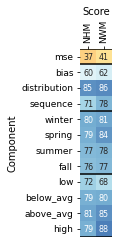

In [13]:
# plot a single score card
from dscore import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (3.54, 3.5))
plot.ilamb_card(score_card, 
                ax=ax,
                hlines=[0,1,4,8,12])
ax.set_xlabel('Score')
fig.tight_layout()

Or plot multiple cards with `multi_panel_card()`:

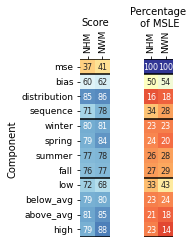

In [14]:
# TODO reverse cbar on second panel

fig = plot.multi_panel_card(score_cards = [score_card, percentage_card],
                            score_labels = ['Score', 'Percentage\n of MSLE'],
                            hlines=[0,1,4,8,12],
                            figsize=(3.54,3.5))
fig.tight_layout()

## Shutdown

In [15]:
cluster.close()
client.close()

## References

Falcone, J. A. (2011). Gages-II: Geospatial attributes of gages for evaluating streamflow.
U.S. Geological Survey dataset. doi:10.3133/70046617

Geman, S., Bienenstock, E., & Doursat, R. (1992). Neural networksand the bias/variance dilemma. Neural Computation, 4 (1), 158. 
doi:10.1162/neco.1992.4.1.1

Hodson, T.O., Over, T.M., and Foks, S.F. (expected 2021). Mean squared error, deconstructed.
Journal of Advances in Modeling Earth Systems.